In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dist(i, j):
    return abs(i[0] - j[0]) + abs(i[1] - j[0])

In [3]:
class KMeans:
    
    def __init__(self, clusters, maxIterations):
        self.k = clusters
        self.maxiter = maxIterations
        
    def getKRandomCentroids(self, points):
        return points[np.random.randint(points.shape[0], size=self.k)]
    
    def computeDistances(self, cts, pts):
        return np.linalg.norm(pts - cts, axis=1)
    
    def run(self, path, plot):
        # Path can be .npy files like the one provided in assignment handout
        X = np.load(path)

        k = self.k
        maxiter = self.maxiter

        # Initialize our centroids by picking random data points
        centroids = self.getKRandomCentroids(X)

        # Initialize classes and distances vectors
        classes = np.zeros(X.shape[0], dtype=np.float64)
        distances = np.zeros([X.shape[0], k], dtype=np.float64)

        # Loop for the maximum number of iterations
        for i in range(maxiter):

            # Assign all points to the nearest centroid
            for i, c in enumerate(centroids):
                distances[:, i] = self.computeDistances(c, X)

            # Assign classes to each point
            classes = np.argmin(distances, axis=1)

            # Compute new centroids
            for c in range(k):
                centroids[c] = np.mean(X[classes == c], 0)

        siVals = 0.0

        for id in range(0,k):
            for i, eli in enumerate(X):
                if (classes[i] != id):
                    continue
                # Now, 'eli' is an element from cluster 'id', and 'i' is its index
                
                ai = 0.0
                bi = 1000000000.0
                si = 0.0
                
                # Finding ai -----
                asum = 0.0
                anum = 0.0
                
                for j, elj in enumerate(X):
                    if (i == j or classes[j] != id):
                        continue
                    # Now, 'elj' is an element from cluster 'id' different from eli, and 'j' is its index
                    asum += dist(eli, elj)
                    anum += 1
                if (anum != 0):
                    ai = asum/anum
                # ai found successfully
                
                # Finding bi -----
                bsum = np.zeros(k, dtype=np.float64)
                bnum = np.zeros(k, dtype=np.float64)
                for j, elj in enumerate(X):
                    if (classes[j] == id):
                        continue
                    # Now, elj is an element from cluster other than 'id'
                    bsum[classes[j]] += dist(eli, elj)
                    bnum[classes[j]] += 1
                
                for i in range(0,k):
                    if bnum[i] != 0:
                        bsum[i] = bsum[i]/bnum[i]
                    if bsum[i] != 0 and bsum[i] < bi:
                        bi = bsum[i]
                # bi found successfully
                si = (bi - ai)/max(ai, bi)
                siVals += si
                
        silhouetteScore = siVals/X.shape[0]
        print(f"The Silhouette Score for k = {k} is {silhouetteScore}")    
        
        if (plot):
            totalColorSet = ['tomato', 'yellowgreen', 'turquoise', 'navajowhite', 'slategray', 'blueviolet', 'r', 'g', 'b', 'y']
            colors = [totalColorSet[0:k][j] for j in classes]

            fig, ax = plt.subplots(figsize=(4,4))
            ax.scatter(X[:,0], X[:,1], color=colors, alpha=0.5)
            ax.scatter(centroids[:,0], centroids[:,1], color=totalColorSet[0:k], marker='o', lw=2)
            ax.set_xlabel('x-coordinate')
            ax.set_ylabel('y-coordinate')


In [ ]:
# We run tests from 2 to 10 (inclusive)
# (Skipping 1 as the silhouette score for 1 cluster is very close to 1 by default)
for k in range(2,11):
    clustering = KMeans(k, 10)
    clustering.run('kmeans_data.npy', False)

### Plotting silhouette score v/s k-value
All values in the ypoints array have been experimentally determined over several consecutive runs.

Since the graph peaks at K=5, we conclude that it is the optimal clustering value.

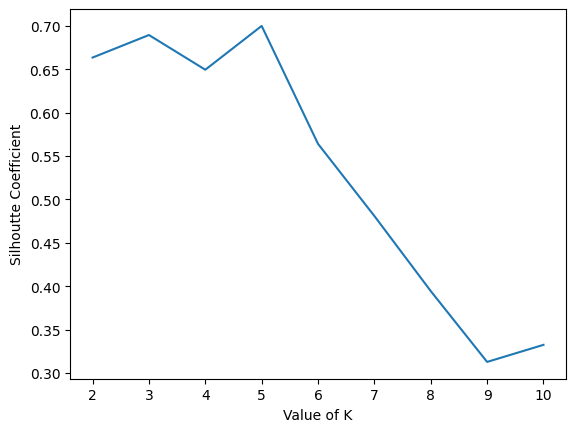

In [4]:
ypoints = np.array([0.6633637936928692, 0.6893353493086484, 0.6493509450974746, 0.6998161667458615, 0.5639275795331706, 0.48080277433044866, 0.3943135773459358, 0.3126727972914914, 0.3323466269886418])

plt.plot(ypoints)
plt.xlabel('Value of K')
plt.ylabel('Silhoutte Coefficient')
plt.xticks((0,1,2,3,4,5,6,7,8), (2,3,4,5,6,7,8,9,10))
plt.show()


The Silhouette Score for k = 5 is 0.6971161667458617


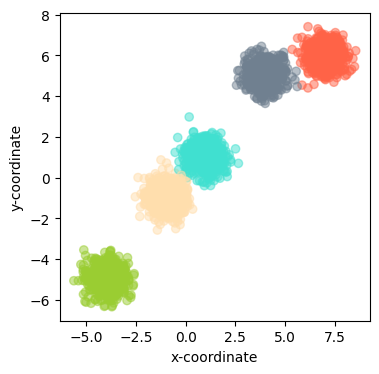

In [9]:
clustering = KMeans(5, 1000)
clustering.run('kmeans_data.npy', True)

In [7]:
class FuzzyCMeans:
    
    def __init__(self, clusters, maxIterations, beta):
        self.k = clusters
        self.maxiter = maxIterations
        self.beta = beta
        
    def getKRandomCentroids(self, points):
        return points[np.random.randint(points.shape[0], size=self.k)]
    
    def computeDistances(self, cts, pts):
        return np.linalg.norm(pts - cts, axis=1)
    
    def mu(self, i, j, distances):
        rec = 0
        for c in range(self.k):
            if (distances[i, c] != 0):
                rec += (distances[i, j]/distances[i, c])**2
        if (rec != 0):
            rec = 1/rec
        return rec
    
    def newCentroids(self, X, membershipTable):
        new = np.zeros([self.k, 2])
        for j in range(self.k):
            num_x = 0
            num_y = 0
            den = 0
            for i in range(X.shape[0]):
                num_x += (membershipTable[i, j]**2)*X[i, 0]
                num_y += (membershipTable[i, j]**2)*X[i, 1]
                den += (membershipTable[i, j]**2)
            if (den != 0):
                new[j, 0] = num_x/den
                new[j, 1] = num_y/den
        return new
                
    def JValue(self, X, membershipTable, centroids):
        J = 0
        for i in range(X.shape[0]):
            for j in range(self.k):
                J += ((membershipTable[i, j]**2)*((X[i,0]-centroids[j,0])**2 + (X[i,1]-centroids[j,1])**2))
        return J
    
    def run(self, path):
        X = np.load(path)
        k = self.k
        maxiter = self.maxiter
        
        centroids = self.getKRandomCentroids(X)
        
        membershipTable = np.zeros([X.shape[0], k], dtype='float64')
        distances = np.zeros([X.shape[0], k], dtype='float64')
        
        J = 100000000000
        for var in range(maxiter):
            for c_id, c in enumerate(centroids):
                distances[:, c_id] = self.computeDistances(c, X)
                
            for i in range(X.shape[0]):
                for j in range(self.k):
                    membershipTable[i, j] = self.mu(i, j, distances)
            
            centroids = self.newCentroids(X, membershipTable)
            
            if (abs(self.JValue(X, membershipTable, centroids) - J) < self.beta):
                print(J, '(acheived convergence)')
                break
            J = self.JValue(X, membershipTable, centroids)
            print(J, end='\r')

In [8]:
fuzzy = FuzzyCMeans(5, 30, 0.2)
fuzzy.run('kmeans_data.npy')

1303.1902738248307 (acheived convergence)
